In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm
from matplotlib.colors import Normalize

In [2]:
from sklearn.cross_decomposition import PLSRegression
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
def pgl(df, ax, cmm):
    age_pc_pls = df.groupby('age').mean()
    # Convert to DataFrame for easier rolling operation
    df_pls = pd.DataFrame(age_pc_pls)

    # Apply rolling window average for PLS
    window_size = 2  # Adjust the window size as needed
    df_smooth_pls = df_pls.rolling(window=window_size, min_periods=1, center=True).mean()

    # Create segments for LineCollection from the smoothed data for PLS
    points_pls = np.array([df_smooth_pls['dim1'], df_smooth_pls['dim2']]).T.reshape(-1, 1, 2)
    segments_pls = np.concatenate([points_pls[:-1], points_pls[1:]], axis=1)

    # Create the line collection object for PLS
    lc_pls = LineCollection(segments_pls, cmap=cmm, norm=plt.Normalize(0, 1), linewidth=1)
    lc_pls.set_array(np.linspace(0, 1, len(df_smooth_pls['dim1'])))

    # Create the outer black line collection for PLS
    black_lc_pls = LineCollection(segments_pls, colors='black', linewidth=2)

    # Add the black line collection to the plot for PLS
    ax.add_collection(black_lc_pls)

    # Add line collection to the plot for PLS
    ax.add_collection(lc_pls)
    ax.autoscale()

In [5]:
format_plots()

In [6]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-30-longtogeny_v2_males_raw_usage_df_beh_age.parquet').groupby(['age','mouse']).mean()
f_df =  pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-30-longtogeny_v2_females_raw_usage_df_beh_age.parquet').groupby(['age','mouse']).mean()
f_df = f_df.query('mouse!="F4_03"')
m_df['sex'] = 'm'
m_df.set_index('sex', inplace = True, append=True)
f_df['sex'] = 'f'
f_df.set_index('sex', inplace = True, append=True)

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])

## PLS regression

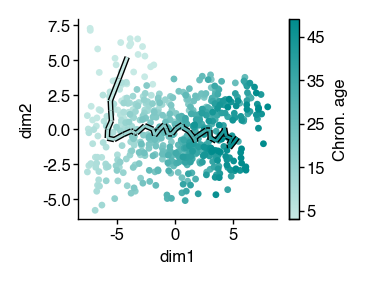

In [7]:
#df = m_norm.copy()
df=m_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
age_pc_pls = pcs_pls.groupby('age').mean()


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1.6,1.3))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
pgl(age_pc_pls, ax, cmm)


# Add color bar
norm = plt.Normalize(vmin=pcs_pls['age'].min(), vmax=pcs_pls['age'].max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Create color bar and set ticks
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Chron. age')
cbar.set_ticks([5, 15, 25, 35, 45])
cbar.set_ticks([5, 15, 25, 35, 45])

sns.despine()
plt.show()

In [8]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ '07_31_PLS_embedding_male_raw_beh_age.pdf')

## PLS regression

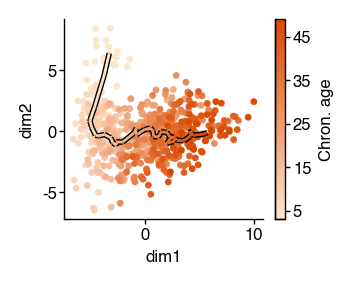

In [9]:
#df = m_norm.copy()
cmm=cmf
df=f_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
age_pc_pls = pcs_pls.groupby('age').mean()


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1.6,1.3))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
pgl(age_pc_pls, ax, cmf)

# Add color bar
norm = plt.Normalize(vmin=pcs_pls['age'].min(), vmax=pcs_pls['age'].max())
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])

# Create color bar and set ticks
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Chron. age')
cbar.set_ticks([5, 15, 25, 35, 45])
cbar.set_ticks([5, 15, 25, 35, 45])

sns.despine()
plt.show()

In [10]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ '07_31_PLS_embedding_female_raw_beh_age.pdf')

In [11]:
## joint plotting

In [12]:
#df = m_norm.copy()
df=combined_df.copy()
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female

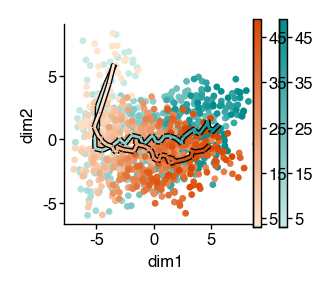

In [13]:
# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
pcs_pls['sex'] = df.index.get_level_values('sex')

fig, ax = plt.subplots(figsize=(1.3,1.3))

#get and plot the male data
pcs_male = pcs_pls.query('sex=="m"').drop(columns=['sex'])
sns.scatterplot(data=pcs_male, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_male, ax, cmm)


# Add color bar for male data
norm_male = Normalize(vmin=pcs_male['age'].min(), vmax=pcs_male['age'].max())
sm_male = plt.cm.ScalarMappable(cmap=cmm, norm=norm_male)
sm_male.set_array([])

# Position color bar for male data
cbar_ax_male = fig.add_axes([0.95, 0.1, 0.03, 0.80])  # [left, bottom, width, height]
cbar_male = fig.colorbar(sm_male, cax=cbar_ax_male)
cbar_male.set_ticks([5, 15, 25, 35, 45])
cbar_male.set_ticklabels([5, 15, 25, 35, 45])

#get and plot the female data
pcs_female = pcs_pls.query('sex=="f"').drop(columns=['sex'])
sns.scatterplot(data=pcs_female, x='dim1', y='dim2', hue='age', palette=cmf, legend=False, s=6, edgecolor='none', ax=ax)
pgl(pcs_female, ax, cmf)

# Add color bar for female data
norm_female = Normalize(vmin=pcs_female['age'].min(), vmax=pcs_female['age'].max())
sm_female = plt.cm.ScalarMappable(cmap=cmf, norm=norm_female)
sm_female.set_array([])

# Position color bar for female data
cbar_ax_female = fig.add_axes([0.85, 0.1, 0.03, 0.80])  # [left, bottom, width, height]
cbar_female = fig.colorbar(sm_female, cax=cbar_ax_female)
cbar_female.set_ticks([5, 15, 25, 35, 45])
cbar_female.set_ticklabels([5, 15, 25, 35, 45])

sns.despine()
plt.show()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ '07_31_PLS_regression_fvm_beh_age.pdf')